# Face recognition

In [1]:
import gc
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import timm  # https://timm.fast.ai/
import torch
from torch.nn import functional as F
from skimage import io
from torch import nn
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm

print(torch.__version__)

1.13.0a0+fb


In [2]:
SEED = 42
np.random.seed(SEED)

### Get data

In [ ]:
!rm -rf lfw_funneled lfw_funneled_v2
!tar -xf lfw_funneled_v2.tar.xz
!mv lfw_funneled lfw_funneled_v2

In [ ]:
!ls -la lfw_funneled_v2/Yoko_Ono/ | head
!ls -la lfw_funneled_v2 | head

In [3]:
DATA_DIR = 'lfw_funneled_v2'

In [4]:
people_multi_photos_data = {}
people_all_data = {}
total_photos = 0

for person_name in os.listdir(DATA_DIR):
    person_name_dir = os.path.join(DATA_DIR, person_name)

    if not os.path.isdir(person_name_dir):
        continue

    pic_files = []

    for picture in os.listdir(person_name_dir):
        person_name_pic = os.path.join(DATA_DIR, person_name, picture)

        if not os.path.isfile(person_name_pic):
            continue

        pic_files.append(torch.from_numpy(io.imread(person_name_pic)).permute(2, 0, 1) / 255.0)
        total_photos += 1

    if not pic_files:
        continue

    people_all_data[person_name] = pic_files

    if len(pic_files) > 1:
        people_multi_photos_data[person_name] = pic_files

people_all_names = list(people_all_data.keys())

print(f"Number of people with multiple pics: {len(people_multi_photos_data)}")
print(f"Total number of people: {len(people_all_data)}")

Number of people with multiple pics: 1679
Total number of people: 5738


In [5]:
class ModelDataset(IterableDataset):
    def __init__(self, people_multi_photos_data, people_all_data, size, *args, **kwargs):
        IterableDataset.__init__(self, *args, **kwargs)

        self.people_multi_photos_data = people_multi_photos_data
        self.people_all_data = people_all_data
        self.size = size

    def a_random_sample(self):
        anchor_person_name, anchor_pic_files = random.choice(list(self.people_multi_photos_data.items()))

        pic_file_positive_idx = pic_file_anchor_idx = random.randint(0, len(anchor_pic_files) - 1)

        while pic_file_anchor_idx == pic_file_positive_idx:
            pic_file_positive_idx = random.randint(0, len(anchor_pic_files) - 1)

        negative_person_name = anchor_person_name
        while negative_person_name == anchor_person_name:
            negative_person_name = random.choice(people_all_names)

        return [
            anchor_pic_files[pic_file_anchor_idx],
            anchor_pic_files[pic_file_positive_idx],
            random.choice(people_all_data[negative_person_name]),
        ]

    def __len__(self):
        # print(f"size {self.size}")
        return self.size

    def __getitem__(self, *args, **kwargs):
        return self.a_random_sample()

    def __iter__(self):
        for _ in range(self.size):
            yield self.a_random_sample()

In [6]:
train_set = ModelDataset(people_multi_photos_data, people_all_data, 50000)
# valid_set = ModelDataset(people_multi_photos_valid, people_all_data, 2500)

#### Prepare a dataset of triplets

### Create APN Dataset 

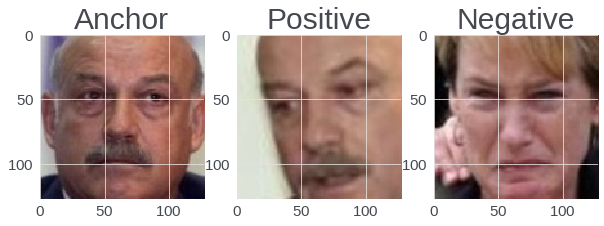

In [7]:
idx = 90
A, P, N = train_set[idx]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1, 2, 0)), cmap='gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1, 2, 0)), cmap='gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1, 2, 0)), cmap='gray');

### Load Dataset into Batches

In [8]:
BATCH_SIZE = 8

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
# valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

print(f'No. of batches in trainloader: {len(train_loader)}')
# print(f'No. of batches in validloader: {len(valid_loader)}')

No. of batches in trainloader: 6250


In [9]:
for A, P, N in train_loader:
    break
    
print(f'One image batch shape : {A.shape}')

One image batch shape : torch.Size([8, 3, 128, 128])


### Create Model 

In [10]:
EMBEDDING_SIZE = 300
DEVICE = 'cuda'

In [11]:
class APN_Model(nn.Module):
    def __init__(self, emb_size=EMBEDDING_SIZE):
        super(APN_Model, self).__init__()

        self.efficient_net = timm.create_model("efficientnet_b0", pretrained=False)
        self.efficient_net.load_state_dict(torch.load("/var/svcscm/efficientnet_b0_ra-3dd342df.pth"))
        self.efficient_net.classifier = nn.Linear(in_features=self.efficient_net.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficient_net(images)

        return embeddings

In [12]:
gc.collect()
torch.cuda.empty_cache()

In [13]:
model = APN_Model()
model.to(DEVICE);

### Create Train and Eval function

In [14]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for ancor, pos, neg in tqdm(data_loader):
        ancor, pos, neg = ancor.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)

        with torch.no_grad():
            embs_ancor = model(ancor)
        embs_pos = model(pos)
        embs_neg = model(neg)

        loss = criterion(embs_ancor, embs_pos, embs_neg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss

    return total_loss / len(data_loader)

In [15]:
def valid(model, data_loader, criterion):
    model.eval()
    total_loss = .0

    for ancor, pos, neg in tqdm(data_loader):
        ancor, pos, neg = ancor.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)

        embs_ancor = model(ancor)
        embs_pos = model(pos)
        embs_neg = model(neg)

        loss = criterion(embs_ancor, embs_pos, embs_neg)
        total_loss += loss

    return total_loss / len(data_loader)

In [28]:
LR = 0.000000001


def criterion(a, p, n):
    return torch.mean(torch.square(1 - F.cosine_similarity(a, p)) - torch.square(1 - F.cosine_similarity(a, n)) + 4)


# criterion = nn.TripletMarginLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.6)

In [26]:
EPOCHS = 50
MODEL_VERSION = "0.3.1"

In [29]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)

    gc.collect()
    torch.cuda.empty_cache()

    # valid_loss = valid(model, valid_loader, criterion)

    if train_loss < best_valid_loss:
        torch.save(model.state_dict(), f"best_model_{MODEL_VERSION}.pt")
        best_valid_loss = train_loss
        print("###### Saved weight success")

    print(f"### Epochs: {i + 1} / train_loss: {train_loss}")

100%|██████████| 6250/6250 [09:49<00:00, 10.60it/s]


###### Saved weight success
### Epochs: 1 / train_loss: 2.055455207824707


100%|██████████| 6250/6250 [09:54<00:00, 10.51it/s]


### Epochs: 2 / train_loss: 2.0689125061035156


100%|██████████| 6250/6250 [09:49<00:00, 10.60it/s]


### Epochs: 3 / train_loss: 2.0615057945251465


100%|██████████| 6250/6250 [09:50<00:00, 10.59it/s]


###### Saved weight success
### Epochs: 4 / train_loss: 2.0477216243743896


100%|██████████| 6250/6250 [09:47<00:00, 10.65it/s]


### Epochs: 5 / train_loss: 2.049145221710205


100%|██████████| 6250/6250 [09:37<00:00, 10.82it/s]


###### Saved weight success
### Epochs: 6 / train_loss: 2.041349411010742


100%|██████████| 6250/6250 [09:46<00:00, 10.66it/s]


### Epochs: 7 / train_loss: 2.051654577255249


100%|██████████| 6250/6250 [09:40<00:00, 10.77it/s]


### Epochs: 8 / train_loss: 2.0580670833587646


100%|██████████| 6250/6250 [09:39<00:00, 10.78it/s]


### Epochs: 9 / train_loss: 2.045978546142578


100%|██████████| 6250/6250 [09:49<00:00, 10.61it/s]


### Epochs: 10 / train_loss: 2.051701784133911


100%|██████████| 6250/6250 [09:41<00:00, 10.75it/s]


### Epochs: 11 / train_loss: 2.069891929626465


100%|██████████| 6250/6250 [09:46<00:00, 10.66it/s]


### Epochs: 13 / train_loss: 2.063000202178955


 54%|█████▍    | 3366/6250 [05:20<04:34, 10.50it/s]


KeyboardInterrupt: 

In [18]:
model.load_state_dict(torch.load(f"best_model_{MODEL_VERSION}.pt"))

<All keys matched successfully>

### Evaluation

In [ ]:
def img_2_vec(model: APN_Model, img_path: str) -> np.ndarray:
    """Gets the path to an image of some face and returns a vector representation for this face."""
    with torch.no_grad():
        img = io.imread(img_path)
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
        vec = model(img.unsqueeze(0))

    return vec.squeeze().numpy()

In [ ]:
model.eval()

with torch.no_grad():
    for i, (ancor, pos, neg) in enumerate(df_valid.values[:20]):
        embs_ancor = img_2_vec(model, ancor)
        embs_pos = img_2_vec(model, pos)
        embs_neg = img_2_vec(model, neg)

        print(
            i,
            f"Positive: {cosineSimilarity([embs_ancor], [embs_pos])[0]}",
            f"Negative: {cosineSimilarity([embs_ancor], [embs_neg])[0]}",
        )

In [ ]:
# interesting examples from valid_set: 0, 17

idx = 9
A, P, N = df_valid.iloc[idx]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title("Anchor")
ax1.imshow(io.imread(A), cmap="gray")

ax2.set_title("Positive")
ax2.imshow(io.imread(P), cmap="gray")

ax3.set_title("Negative")
ax3.imshow(io.imread(N), cmap="gray")